In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,models,backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy

In [12]:
(x_train, y_train ), (x_valid, y_valid ) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_valid = x_valid.astype('float32') / 255.0

x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_valid = np.reshape(x_valid, (-1 ,28, 28, 1))

In [4]:
latent_dim = 3

# Encoder
inputs = layers.Input(shape=(28, 28, 1))
conv1 = layers.Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(inputs)
conv2 = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(conv1)
x = layers.Flatten()(conv2)
x = layers.Dense(16, activation='relu')(x)

z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)


# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


# Latent space sampling
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │     50,192 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 3)         │         51 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 3)         │         51 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 3)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,110 (269.96 KB)

 Trainable params: 69,110 (269.96 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(x)
outputs = layers.Conv2DTranspose(1, kernel_size=3, activation='sigmoid', padding='same')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,225 (266.50 KB)

 Trainable params: 68,225 (266.50 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
class VAEModel(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        
        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # Compute reconstruction loss without flattening
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    binary_crossentropy(data, reconstruction), axis=(1, 2) 
                )
            )
            reconstruction_loss *= 28 * 28
            
            # Compute KL divergence loss
            kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=-1))
            kl_loss *= -0.5
        
            total_loss = reconstruction_loss + kl_loss
        
        # Compute gradients
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}

vae = VAEModel(encoder, decoder)
vae.compile(optimizer='adam', loss=lambda y_true, y_pred: 0.0)
vae.summary()

Model: "vae_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ [(None, 3), (None, 3), │        69,110 │
│                                 │ (None, 3)]             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │        68,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,335 (536.46 KB)

 Trainable params: 137,335 (536.46 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
vae.load_weights('mnist.weights.h5')

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


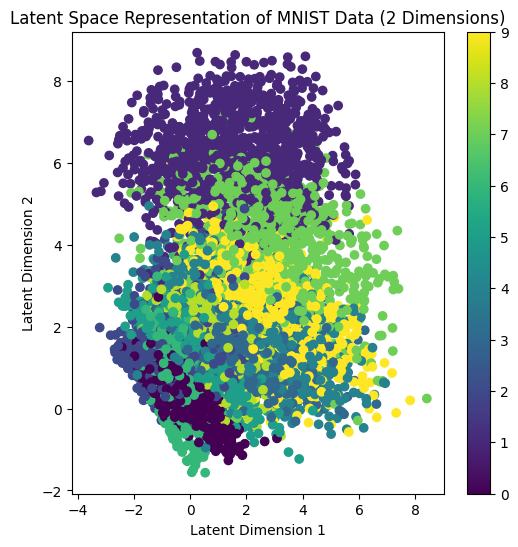

In [36]:
# Predict using the encoder to get the latent space representation
x_test_encoded = encoder.predict(x_valid, batch_size=128)[2]  

x_test_encoded_2d = x_test_encoded[:, :] 

# Plotting the 2D scatter plot of the latent space
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded_2d[:, 2], x_test_encoded_2d[:, 1], c=y_valid, cmap='viridis')  # Use y_valid directly for coloring
plt.colorbar()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Representation of MNIST Data (2 Dimensions)')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

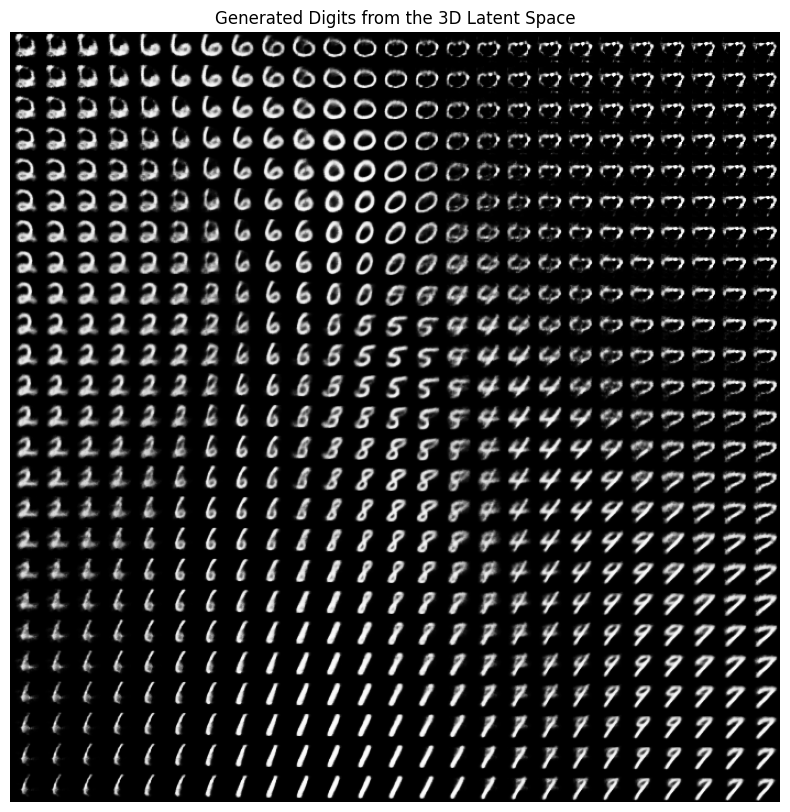

In [14]:
n = 25  # Number of images per dimension
digit_size = 28 
figure = np.zeros((digit_size * n, digit_size * n)) 

# Linearly spaced coordinates for creating the grid
grid_x = np.linspace(-6, 6, n)
grid_y = np.linspace(-1, 5, n)

# Iterate over the grid to fill in digits generated from the latent space
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        # Create a 3D latent space sample with the first two dimensions varying, and the third dimension fixed
        z_sample = np.array([[xi, yi,0]])  
        x_decoded = decoder.predict(z_sample)  
        digit = x_decoded[0].reshape(digit_size, digit_size)  
        
        # Place the generated digit in the right location of the large canvas
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

# Plot the generated digits
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.title('Generated Digits from the 3D Latent Space')
plt.axis('off')
plt.show()


In [15]:

latent_vectors = encoder.predict(x_valid)[0]  

latent_vectors_by_class = {i: [] for i in range(10)}

for latent_vector, label in zip(latent_vectors, y_valid):
    latent_vectors_by_class[label].append(latent_vector)

avg_latent_vectors = {i: np.mean(latent_vectors_by_class[i], axis=0) for i in range(10)}

for digit_class, avg_vector in avg_latent_vectors.items():
    print(f"Average latent vector for digit {digit_class}: {avg_vector}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Average latent vector for digit 0: [-0.6194384   0.34998435 -0.0668366 ]
Average latent vector for digit 1: [-1.6068738  6.086022   1.5502806]
Average latent vector for digit 2: [-4.241847    1.4715383   0.05203413]
Average latent vector for digit 3: [-2.1412451  1.5502455  2.1146774]
Average latent vector for digit 4: [2.4364274 2.0223472 2.314406 ]
Average latent vector for digit 5: [-0.3723287  1.4010544  0.4291114]
Average latent vector for digit 6: [-1.9804045  0.9799376 -0.3447484]
Average latent vector for digit 7: [5.8482246 4.058806  2.7265158]
Average latent vector for digit 8: [-0.39408913  1.8816482   1.2449949 ]
Average latent vector for digit 9: [3.0452776 2.3995905 2.827466 ]


In [34]:
from PIL import Image
def save_nparray(figure,path):
    image=Image.fromarray(np.uint8(figure * 255))
    image.convert('L')
    image.save(path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

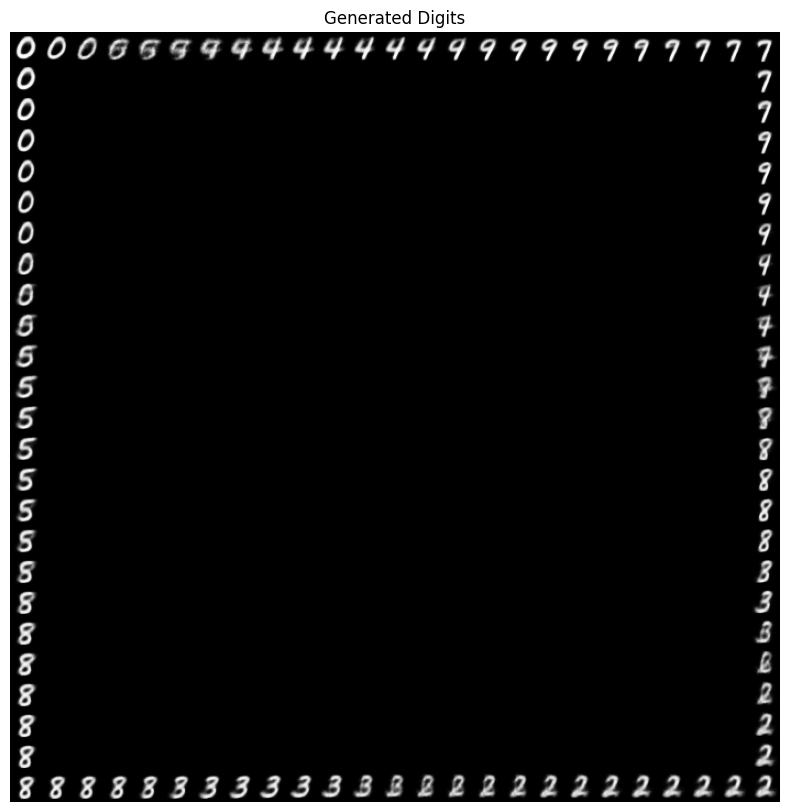

In [66]:
def plot_between(d1,d2,figure,axis,flag):
    point1 = avg_latent_vectors[d1]
    point2 = avg_latent_vectors[d2]

    n = 25 
    t_values = np.linspace(0, 1, n)


    if(axis ==0):
        j=0 if (flag==0) else n-1
        for i,t in enumerate(t_values):
            z_sample=np.array([(1 - t) * point1 + t * point2])
            x_decoded = decoder.predict(z_sample)  
            digit = x_decoded[0].reshape(digit_size, digit_size)  
            figure[i * digit_size: (i + 1) * digit_size,j*(digit_size): (j+1)*digit_size] = digit
    else:
        i=0 if (flag==0) else n-1
        for j,t in enumerate(t_values):
            z_sample=np.array([(1 - t) * point1 + t * point2])
            x_decoded = decoder.predict(z_sample)  
            digit = x_decoded[0].reshape(digit_size, digit_size)  
            figure[i * digit_size: (i + 1) * digit_size,j*(digit_size): (j+1)*digit_size] = digit
        
figure = np.zeros((digit_size * n, digit_size*n))
plot_between(0,8,figure,0,0)
plot_between(0,7,figure,1,0)
plot_between(7,2,figure,0,1)
plot_between(8,2,figure,1,1)

save_nparray(figure,'Images/frame.png')
    
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.title('Generated Digits')
plt.axis('off')
plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


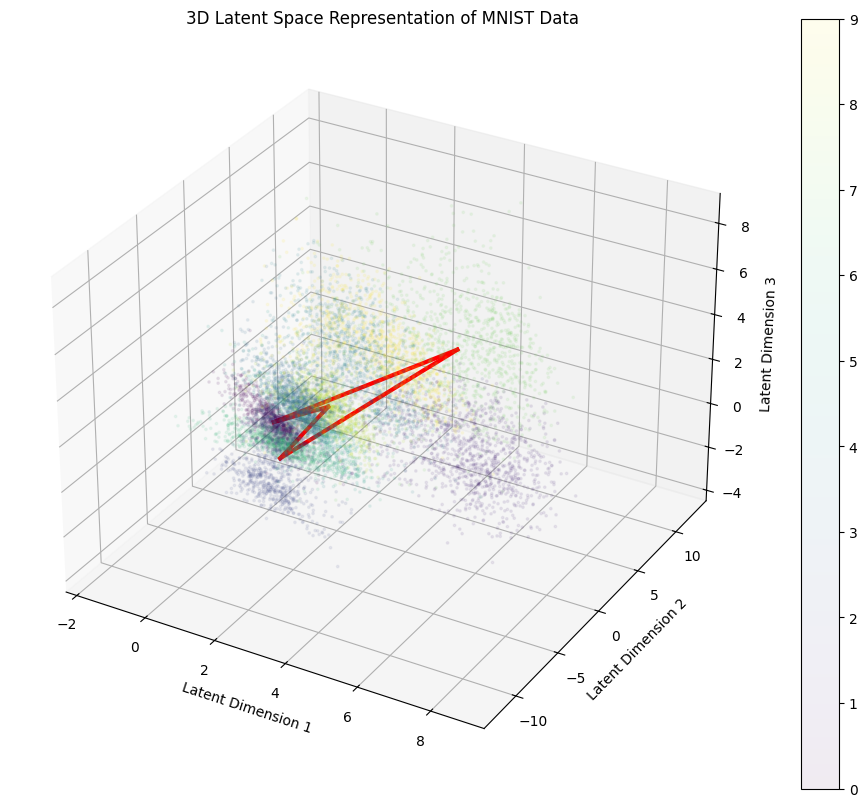

In [65]:
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
import matplotlib.pyplot as plt
import numpy as np

# Encode the entire test dataset
x_test_encoded_3d = encoder.predict(x_valid, batch_size=128)[2]

x_test_encoded_3d = np.array(x_test_encoded_3d)

if y_valid.ndim > 1:
    y_valid_labels = np.argmax(y_valid, axis=1)
else:
    y_valid_labels = y_valid

# Plotting the 3D scatter plot of the latent space
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three dimensions of the latent space
scatter = ax.scatter(
    
    x_test_encoded_3d[:, 1],
    x_test_encoded_3d[:, 0],
    
    x_test_encoded_3d[:, 2], 
     
    c=y_valid,
    cmap='viridis',
    alpha=0.08,  # Transparency for better visualization
    s=3  # Size of the points
)

# Adding labels and a color bar
plt.colorbar(scatter)
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.title('3D Latent Space Representation of MNIST Data')


point_1=avg_latent_vectors[0]
point_2=avg_latent_vectors[7]
ax.plot(
    [point_1[1], point_2[1]],  # Y axis
    [point_1[0], point_2[0]],  # X axis
    [point_1[2], point_2[2]],  # Z axis
    color='red', linewidth=3, linestyle='-'  # Customize the line
)

point_1=avg_latent_vectors[0]
point_2=avg_latent_vectors[8]
ax.plot(
    [point_1[1], point_2[1]],  # Y axis
    [point_1[0], point_2[0]],  # X axis
    [point_1[2], point_2[2]],  # Z axis
    color='red', linewidth=3, linestyle='-'  # Customize the line
)

point_1=avg_latent_vectors[7]
point_2=avg_latent_vectors[2]
ax.plot(
    [point_1[1], point_2[1]],  # Y axis
    [point_1[0], point_2[0]],  # X axis
    [point_1[2], point_2[2]],  # Z axis
    color='red', linewidth=3, linestyle='-'  # Customize the line
)

point_1=avg_latent_vectors[8]
point_2=avg_latent_vectors[2]
ax.plot(
    [point_1[1], point_2[1]],  # Y axis
    [point_1[0], point_2[0]],  # X axis
    [point_1[2], point_2[2]],  # Z axis
    color='red', linewidth=3, linestyle='-'  # Customize the line
)

plt.savefig('Images/3d_LinePlot_MNIST.png', dpi=300, bbox_inches='tight')
plt.show()
